### MSCA 31009 - Winter 2022 - Final Project - Book Recommender - Peter Ryan

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from surprise import NMF
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise import Reader, Dataset

In [2]:
books_df = pd.read_csv('/Users/paryan414/UofC/MSCA 31009 MLPA/Final Project/books_dataset.csv')

/Users/paryan414/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### EDA

In [3]:
books_df.shape

(753298, 12)

In [4]:
books_df.head()

,User_ID,Age,Location,City,State,Country,ISBN,Book_Title,Book_Author,Year_Of_Publication,Publisher,Book_Rating
0,2,18,"stockton, california, usa",stockton,california,usa,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,0
1,11400,49,"ottawa, ontario, canada",ottawa,ontario,canada,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,0
2,67544,30,"toronto, ontario, canada",toronto,ontario,canada,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,8
3,85526,36,"victoria, british columbia, canada",victoria,british columbia,canada,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,0
4,96054,29,"ottawa, ontario, canada",ottawa,ontario,canada,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,0


In [5]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753298 entries, 0 to 753297
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   User_ID              753298 non-null  int64 
 1   Age                  753298 non-null  int64 
 2   Location             753298 non-null  object
 3   City                 751534 non-null  object
 4   State                752634 non-null  object
 5   Country              742672 non-null  object
 6   ISBN                 753298 non-null  object
 7   Book_Title           753298 non-null  object
 8   Book_Author          753298 non-null  object
 9   Year_Of_Publication  753298 non-null  object
 10  Publisher            753298 non-null  object
 11  Book_Rating          753298 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 69.0+ MB


An **ISBN** is an **International Standard Book Number.** ISBNs were 10 digits in length up to the end of December 2006, 
but since 1 January 2007 they now always consist of 13 digits. ISBNs are calculated using a specific mathematical 
formula and include a check digit to validate the number.  
Source: https://www.isbn-international.org/content/what-isbn

In [6]:
# How many unique books (ISBN's) are there?  
len(books_df.ISBN.unique())

228998

In [7]:
# How many unique users (User_ID) are there?  
len(books_df.User_ID.unique())

53887

In [8]:
# Breakdown of ratings - original dataset
books_df.Book_Rating.describe()

count    753298.000000
mean          2.768898
std           3.864231
min           0.000000
25%           0.000000
50%           0.000000
75%           7.000000
max          10.000000
Name: Book_Rating, dtype: float64

In [9]:
ratings = books_df.Book_Rating.value_counts(normalize = True)
print(ratings)

0     0.642083
8     0.086052
10    0.071609
7     0.060453
9     0.060068
5     0.036830
6     0.028468
4     0.006765
3     0.004422
2     0.002074
1     0.001176
Name: Book_Rating, dtype: float64


In [10]:
rtg_cat = ratings.index

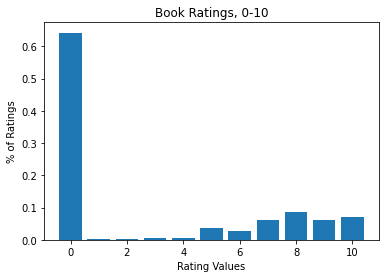

In [11]:
fig, ax = plt.subplots()  # Create a figure containing a single axes.
ax.set_xlabel('Rating Values')
ax.set_ylabel('% of Ratings')
ax.set_title('Book Ratings, 0-10')
ax.bar(rtg_cat, ratings);  # Plot some data on the axes.

In [12]:
# Make a copy of original dataset for bulk of work; refer back to original if needed / reset.
books2 = books_df.copy()

In [13]:
books2.head()

,User_ID,Age,Location,City,State,Country,ISBN,Book_Title,Book_Author,Year_Of_Publication,Publisher,Book_Rating
0,2,18,"stockton, california, usa",stockton,california,usa,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,0
1,11400,49,"ottawa, ontario, canada",ottawa,ontario,canada,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,0
2,67544,30,"toronto, ontario, canada",toronto,ontario,canada,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,8
3,85526,36,"victoria, british columbia, canada",victoria,british columbia,canada,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,0
4,96054,29,"ottawa, ontario, canada",ottawa,ontario,canada,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,0


In [14]:
# Remove rows with 0 ratings - not relevant to analysis if user has not rated them?  Hmmm...
books2 = books2[books2['Book_Rating'] != 0]

In [15]:
# What is shape after removing zeros?
books2.shape

(269618, 12)

In [16]:
# How many rows were dropped?
books_df.shape[0] - books2.shape[0]

483680

In [17]:
books2.head()

,User_ID,Age,Location,City,State,Country,ISBN,Book_Title,Book_Author,Year_Of_Publication,Publisher,Book_Rating
2,67544,30,"toronto, ontario, canada",toronto,ontario,canada,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,8
6,219008,60,"halifax, nova scotia, canada",halifax,nova scotia,canada,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,7
7,263325,27,"fredericton, new brunswick, canada",fredericton,new brunswick,canada,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,6
8,2954,71,"wichita, kansas, usa",wichita,kansas,usa,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,8
9,152827,40,"ottawa, ontario, canada",ottawa,ontario,canada,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,7


In [18]:
# Still many book titles overall
len(books2.ISBN.unique())

119945

In [19]:
# More unique ISBN's than unique Book Titles...Same title with different ISBN?
len(books2.Book_Title.unique())

109210

In [20]:
# How many unique users (User_ID) are there?  
len(books2.User_ID.unique())

40543

In [21]:
# Create a column summing how many reviews each book has.
books2['reviews'] = books2.groupby(['Book_Title'])['Book_Rating'].transform('count')

In [22]:
books2.head()

,User_ID,Age,Location,City,State,Country,ISBN,Book_Title,Book_Author,Year_Of_Publication,Publisher,Book_Rating,reviews
2,67544,30,"toronto, ontario, canada",toronto,ontario,canada,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,8,3
6,219008,60,"halifax, nova scotia, canada",halifax,nova scotia,canada,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,7,3
7,263325,27,"fredericton, new brunswick, canada",fredericton,new brunswick,canada,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,6,3
8,2954,71,"wichita, kansas, usa",wichita,kansas,usa,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,8,2
9,152827,40,"ottawa, ontario, canada",ottawa,ontario,canada,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,7,2


In [23]:
# How many titles have fewer than 4 reviews?  Drop these.
len(books2[books2['reviews'] < 4])

125079

In [24]:
books2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269618 entries, 2 to 753294
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   User_ID              269618 non-null  int64 
 1   Age                  269618 non-null  int64 
 2   Location             269618 non-null  object
 3   City                 268483 non-null  object
 4   State                269243 non-null  object
 5   Country              264820 non-null  object
 6   ISBN                 269618 non-null  object
 7   Book_Title           269618 non-null  object
 8   Book_Author          269618 non-null  object
 9   Year_Of_Publication  269618 non-null  object
 10  Publisher            269618 non-null  object
 11  Book_Rating          269618 non-null  int64 
 12  reviews              269618 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 28.8+ MB


In [25]:
# Keep only titles with more than 3 reviews
books2 = books2[books2['reviews'] > 3]

In [26]:
books2.shape

(144539, 13)

In [27]:
books2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144539 entries, 10 to 753293
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   User_ID              144539 non-null  int64 
 1   Age                  144539 non-null  int64 
 2   Location             144539 non-null  object
 3   City                 144249 non-null  object
 4   State                144376 non-null  object
 5   Country              141695 non-null  object
 6   ISBN                 144539 non-null  object
 7   Book_Title           144539 non-null  object
 8   Book_Author          144539 non-null  object
 9   Year_Of_Publication  144539 non-null  object
 10  Publisher            144539 non-null  object
 11  Book_Rating          144539 non-null  int64 
 12  reviews              144539 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 15.4+ MB


In [28]:
len(books2.Book_Title.unique())

12896

In [29]:
len(books2.User_ID.unique())

29664

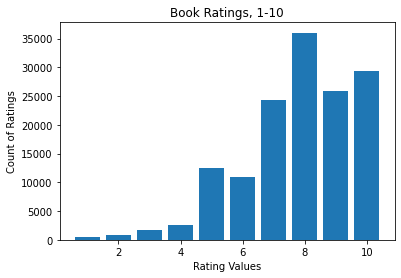

In [30]:
ratings_2 = books2.Book_Rating.value_counts()

rtg_cat2 = ratings_2.index

fig, ax = plt.subplots()  # Create a figure containing a single axes.
ax.set_xlabel('Rating Values')
ax.set_ylabel('Count of Ratings')
ax.set_title('Book Ratings, 1-10')
ax.bar(rtg_cat2, ratings_2);  # Plot some data on the axes.

In [31]:
# books2[books2['User_ID'], books2['Book_Title'], books2['Book_Rating']]

In [32]:
# USE books2 for your basis dataframe to reduce to user_id, book_title, book_rating

In [33]:
# how many users do we have who have only read "a few" or < 5 books?
books2['bks_count'] = books2.groupby(['User_ID'])['Book_Title'].transform('count')

In [34]:
books2.groupby(['Book_Title']).ISBN.count().sort_values(ascending = False)[:10]

Book_Title
Wild Animus                                         473
The Lovely Bones: A Novel                           473
The Da Vinci Code                                   380
The Secret Life of Bees                             280
Bridget Jones's Diary                               261
Angels &amp; Demons                                 258
Life of Pi                                          252
Harry Potter and the Chamber of Secrets (Book 2)    246
The Nanny Diaries: A Novel                          246
The Red Tent (Bestselling Backlist)                 227
Name: ISBN, dtype: int64

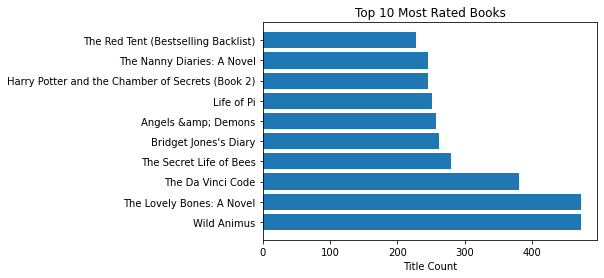

In [35]:
ratings_2 = books2.groupby(['Book_Title']).ISBN.count().sort_values(ascending = False)[:10]

rtg_cat2 = ratings_2.index

fig, ax = plt.subplots()  # Create a figure containing a single axes.
ax.set_xlabel('Title Count')
# ax.set_ylabel('Count of Ratings')
ax.set_title('Top 10 Most Rated Books')
ax.barh(rtg_cat2, ratings_2);  # Plot some data on the axes.

In [36]:
books2.head()

,User_ID,Age,Location,City,State,Country,ISBN,Book_Title,Book_Author,Year_Of_Publication,Publisher,Book_Rating,reviews,bks_count
10,35704,53,"kansas city, missouri, usa",kansas city,missouri,usa,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,6,5,33
12,110912,36,"milpitas, california, usa",milpitas,california,usa,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,10,5,87
14,157969,30,"denver, colorado, usa",denver,colorado,usa,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,8,5,3
15,192665,47,"vacaville, california, usa",vacaville,california,usa,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,8,5,6
16,197659,49,"indiana, pennsylvania, usa",indiana,pennsylvania,usa,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,9,5,186


In [37]:
books2[books2['bks_count'] == 1]

,User_ID,Age,Location,City,State,Country,ISBN,Book_Title,Book_Author,Year_Of_Publication,Publisher,Book_Rating,reviews,bks_count
33,252921,22,"renton, washington, usa",renton,washington,usa,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,8,78,1
58,12923,39,"louisville, kentucky, usa",louisville,kentucky,usa,0440234743,The Testament,John Grisham,1999,Dell,10,154,1
84,46767,24,"leipzig, sachsen, germany",leipzig,sachsen,germany,0440234743,The Testament,John Grisham,1999,Dell,9,154,1
176,131681,48,"muskegon, michigan, usa",muskegon,michigan,usa,0440234743,The Testament,John Grisham,1999,Dell,9,154,1
181,136707,50,"laplace, louisiana, usa",laplace,louisiana,usa,0440234743,The Testament,John Grisham,1999,Dell,6,154,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745139,211521,223,"santa maria da feira, porto, portugal",santa maria da feira,porto,portugal,1557987904,Publication Manual of the American Psychologic...,American Psychological Association,2001,American Psychological Association (APA),5,4,1
747646,228679,26,"hastings, nebraska, usa",hastings,nebraska,usa,1401398391,The Art of Deception,Ridley Pearson,2003,Hyperion Books,8,13,1
751469,240398,41,"manhattan, kansas, usa",manhattan,kansas,usa,0553208861,Flint,Louis L'Amour,1982,Bantam Books,10,10,1
752990,245444,18,"linclon, nebraska, usa",linclon,nebraska,usa,0152049266,The Window,Jeanette Ingold,2003,Harcourt Paperbacks,8,4,1


In [38]:
books2[books2['User_ID'] == 136707]

,User_ID,Age,Location,City,State,Country,ISBN,Book_Title,Book_Author,Year_Of_Publication,Publisher,Book_Rating,reviews,bks_count
181,136707,50,"laplace, louisiana, usa",laplace,louisiana,usa,0440234743,The Testament,John Grisham,1999,Dell,6,154,1


In [39]:
len(books2.bks_count.unique())

170

In [40]:
books2.bks_count.describe()

count    144539.000000
mean         54.792181
std         135.198466
min           1.000000
25%           4.000000
50%          17.000000
75%          54.000000
max        1249.000000
Name: bks_count, dtype: float64

In [41]:
len(books2[books2['bks_count'] < 5])

36399

In [42]:
# After consideration, decided to keep everyone who rated at least 1 book

### Dataframe for Modeling

In [43]:
# reduce dataframe to columns with user id, book title and rating
# 'ubr' = user-book-rating
books2_ubr = books2[['User_ID', 'Book_Title', 'Book_Rating']]

In [44]:
books2_ubr.shape

(144539, 3)

In [45]:
books2_ubr.sort_values('User_ID', ascending = False)

,User_ID,Book_Title,Book_Rating
496725,278852,Dave Barry's Only Travel Guide You'll Ever Need,8
279904,278851,"Then Again, Maybe I Won't",5
258907,278851,Captain Underpants and the Wrath of the Wicked...,5
44234,278851,"14,000 Things to Be Happy About",5
5303,278851,Life's Little Instruction Book (Life's Little ...,8
...,...,...,...
4451,56,LONESOME DOVE,7
4171,51,The Street Lawyer,9
4026,44,This Year It Will Be Different: And Other Stories,8
3688,42,From the Corner of His Eye,7


In [46]:
books2_ubr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144539 entries, 10 to 753293
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   User_ID      144539 non-null  int64 
 1   Book_Title   144539 non-null  object
 2   Book_Rating  144539 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.4+ MB


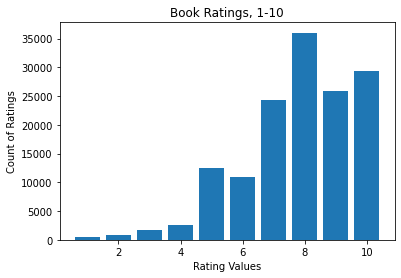

In [47]:
ratings_ubr = books2_ubr.Book_Rating.value_counts()

rtg_cat = ratings_ubr.index

fig, ax = plt.subplots()  # Create a figure containing a single axes.
ax.set_xlabel('Rating Values')
ax.set_ylabel('Count of Ratings')
ax.set_title('Book Ratings, 1-10')
ax.bar(rtg_cat, ratings_ubr);  # Plot some data on the axes.

In [48]:
# Number of unique user ids in the df
len(books2_ubr.User_ID.unique())

29664

In [49]:
# Number of unique book ids in the df
len(books2_ubr.Book_Title.unique())

12896

In [50]:
# Group users by how many books they have read
books2_ubr.groupby(by='User_ID')['Book_Title'].count()

User_ID
19        1
42        1
44        1
51        1
56        1
         ..
278844    1
278846    1
278849    1
278851    4
278852    1
Name: Book_Title, Length: 29664, dtype: int64

In [51]:
books2_ubr['Book_Rating'].describe()

count    144539.000000
mean          7.821937
std           1.770639
min           1.000000
25%           7.000000
50%           8.000000
75%           9.000000
max          10.000000
Name: Book_Rating, dtype: float64

### Beginning of NMF Modeling

In [52]:
# Reader class in Surprise - used to parse files with ratings.
reader = Reader(rating_scale=(1,10))

In [53]:
# Load data in to Surprise
data = Dataset.load_from_df(books2_ubr, reader)

In [54]:
# split in to train and test sets, test set = 20% of data
trainset, testset = train_test_split(data, test_size=.20, random_state = 42)

In [55]:
trainset

In [56]:
# Use built-in Non-negative matrix factorization algorithm
algo = NMF(random_state = 42)

In [57]:
# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)

In [58]:
predictions = algo.test(testset, verbose = True)

user: 117384     item: 365 Read-Aloud Bedtime Bible Stories r_ui = 9.00   est = 7.00   {'was_impossible': False}
user: 79916      item: How to Meet &amp; Work With Spirit Guides (Llewellyn's Practical Guide to Personal Power) r_ui = 8.00   est = 7.82   {'was_impossible': True, 'reason': 'User and item are unknown.'}
user: 70052      item: Recruited: An Alias Prequel r_ui = 5.00   est = 3.99   {'was_impossible': False}
user: 258185     item: Purity in Death r_ui = 10.00   est = 6.66   {'was_impossible': False}
user: 227705     item: The Neverending Story r_ui = 10.00   est = 6.84   {'was_impossible': False}
user: 201684     item: Why Girls Are Weird : A Novel r_ui = 7.00   est = 6.06   {'was_impossible': False}
user: 98391      item: Killer Smile (Scottoline, Lisa) r_ui = 10.00   est = 6.50   {'was_impossible': False}
user: 7202       item: L'Etranger (Collection Folio, 2) r_ui = 8.00   est = 7.82   {'was_impossible': True, 'reason': 'User and item are unknown.'}
user: 128600     item: 

user: 16871      item: Range of Motion r_ui = 9.00   est = 7.04   {'was_impossible': False}
user: 114368     item: Message from Nam r_ui = 10.00   est = 4.35   {'was_impossible': False}
user: 96869      item: Gentle Rogue (Malory Novels (Paperback)) r_ui = 9.00   est = 5.46   {'was_impossible': False}
user: 156467     item: Separated at Birth? r_ui = 10.00   est = 6.42   {'was_impossible': False}
user: 111747     item: Silent Treatment r_ui = 8.00   est = 5.15   {'was_impossible': False}
user: 98391      item: Nighttime Is My Time (Clark, Mary Higgins) r_ui = 10.00   est = 6.94   {'was_impossible': False}
user: 96194      item: When the Wind Blows r_ui = 8.00   est = 5.90   {'was_impossible': False}
user: 25827      item: A Heartbreaking Work Of Staggering Genius : A Memoir Based on a True Story r_ui = 8.00   est = 5.25   {'was_impossible': False}
user: 16634      item: The Drawing of the Three (The Dark Tower, Book 2) r_ui = 8.00   est = 6.51   {'was_impossible': False}
user: 114075  

user: 149250     item: Roses Are Red (Alex Cross Novels) r_ui = 9.00   est = 7.82   {'was_impossible': True, 'reason': 'User and item are unknown.'}
user: 30923      item: The Forever King (Forever King Trilogy) r_ui = 7.00   est = 4.17   {'was_impossible': False}
user: 235099     item: Tears of the Moon (Irish Trilogy) r_ui = 9.00   est = 6.10   {'was_impossible': False}
user: 167812     item: The Dive From Clausen's Pier : A Novel (Vintage Contemporaries (Paperback)) r_ui = 8.00   est = 5.49   {'was_impossible': False}
user: 100906     item: The Tombs of Atuan (Earthsea Trilogy (Paperback)) r_ui = 9.00   est = 4.85   {'was_impossible': False}
user: 96194      item: From Potter's Field r_ui = 9.00   est = 6.06   {'was_impossible': False}
user: 212626     item: Tuck Everlasting r_ui = 8.00   est = 7.82   {'was_impossible': True, 'reason': 'User and item are unknown.'}
user: 112001     item: Cause Celeb r_ui = 8.00   est = 7.68   {'was_impossible': False}
user: 66574      item: Naked Lu

user: 170575     item: The Blessing r_ui = 8.00   est = 6.73   {'was_impossible': False}
user: 128060     item: Castle Roogna (Xanth Novels (Paperback)) r_ui = 10.00   est = 6.37   {'was_impossible': False}
user: 10250      item: Leviathan (Contemporary American Fiction) r_ui = 9.00   est = 7.82   {'was_impossible': True, 'reason': 'User and item are unknown.'}
user: 153342     item: Norman'S Heart (Harlequin Historical, No 311) r_ui = 7.00   est = 5.12   {'was_impossible': False}
user: 147141     item: Bloodsucking Fiends: A Love Story r_ui = 7.00   est = 4.17   {'was_impossible': False}
user: 46351      item: Le Combat ordinaire, tome 1 r_ui = 9.00   est = 7.25   {'was_impossible': False}
user: 209932     item: The Moment She Was Gone : A Novel r_ui = 5.00   est = 4.33   {'was_impossible': False}
user: 107438     item: Weetzie Bat (10th Anniversary Edition) r_ui = 8.00   est = 2.76   {'was_impossible': False}
user: 41831      item: Feeling Good : The New Mood Therapy r_ui = 5.00   es

user: 110112     item: Centaur Aisle r_ui = 6.00   est = 4.35   {'was_impossible': False}
user: 231510     item: It         r_ui = 7.00   est = 8.11   {'was_impossible': False}
user: 179288     item: If I'd Killed Him When I Met Him...: An Elizabeth Mac Pherson Novel r_ui = 5.00   est = 5.87   {'was_impossible': False}
user: 22521      item: Midnight Predator r_ui = 7.00   est = 5.72   {'was_impossible': False}
user: 98686      item: The Door to December r_ui = 8.00   est = 6.82   {'was_impossible': False}
user: 127490     item: Suzanne's Diary for Nicholas r_ui = 5.00   est = 5.79   {'was_impossible': False}
user: 109574     item: Angela's Ashes (MMP) : A Memoir r_ui = 8.00   est = 6.66   {'was_impossible': False}
user: 202358     item: Joe Gould's Secret r_ui = 6.00   est = 5.41   {'was_impossible': False}
user: 70594      item: Fluke : Or, I Know Why the Winged Whale Sings r_ui = 9.00   est = 6.57   {'was_impossible': False}
user: 157247     item: Praying for Sleep r_ui = 9.00   est

user: 166596     item: Cold Sassy Tree r_ui = 8.00   est = 5.57   {'was_impossible': False}
user: 98783      item: The Tale of the Body Thief (Vampire Chronicles (Paperback)) r_ui = 8.00   est = 5.86   {'was_impossible': False}
user: 178458     item: Seabiscuit r_ui = 8.00   est = 6.05   {'was_impossible': False}
user: 148986     item: Seven Up (A Stephanie Plum Novel) r_ui = 5.00   est = 5.84   {'was_impossible': False}
user: 37874      item: Sacrifice  r_ui = 6.00   est = 6.51   {'was_impossible': False}
user: 106131     item: The Devil in the White City: Murder, Magic, and Madness at the Fair that Changed America r_ui = 10.00   est = 6.96   {'was_impossible': False}
user: 13604      item: Prime Cut  r_ui = 8.00   est = 5.29   {'was_impossible': False}
user: 203240     item: Eva Moves the Furniture: A Novel r_ui = 7.00   est = 6.53   {'was_impossible': False}
user: 235935     item: Sisterchicks on the Loose (Sisterchicks) r_ui = 9.00   est = 5.59   {'was_impossible': False}
user: 234

user: 182993     item: Compromising Positions r_ui = 7.00   est = 4.78   {'was_impossible': False}
user: 47581      item: Flight     r_ui = 8.00   est = 6.41   {'was_impossible': False}
user: 15135      item: Hemingway's Chair r_ui = 5.00   est = 4.06   {'was_impossible': False}
user: 28865      item: I Am Spock r_ui = 10.00   est = 7.72   {'was_impossible': False}
user: 62582      item: Postmortem (Kay Scarpetta Mysteries (Paperback)) r_ui = 8.00   est = 7.07   {'was_impossible': False}
user: 156300     item: The List of 7 r_ui = 10.00   est = 7.32   {'was_impossible': False}
user: 104051     item: Dark Rivers of the Heart: A Novel r_ui = 8.00   est = 5.11   {'was_impossible': False}
user: 127914     item: Slow Waltz in Cedar Bend r_ui = 8.00   est = 5.13   {'was_impossible': False}
user: 32219      item: A Darkness More Than Night r_ui = 7.00   est = 7.82   {'was_impossible': True, 'reason': 'User and item are unknown.'}
user: 80826      item: A Widow for One Year r_ui = 10.00   est 

user: 248656     item: Emma (Penguin Classics) r_ui = 6.00   est = 7.27   {'was_impossible': False}
user: 638        item: A Map of the World r_ui = 10.00   est = 6.69   {'was_impossible': False}
user: 233903     item: Macgregor Brides (Macgregors) r_ui = 9.00   est = 6.75   {'was_impossible': False}
user: 241980     item: Desperation r_ui = 10.00   est = 8.21   {'was_impossible': False}
user: 8067       item: Orphans (Orphans Series) r_ui = 10.00   est = 6.65   {'was_impossible': False}
user: 98391      item: Serpent's Dance r_ui = 9.00   est = 5.09   {'was_impossible': False}
user: 274061     item: Secret Fire r_ui = 9.00   est = 7.36   {'was_impossible': False}
user: 174304     item: Into the Garden (Wildflowers) r_ui = 5.00   est = 4.69   {'was_impossible': False}
user: 235105     item: The Subtle Knife (His Dark Materials, Book 2) r_ui = 10.00   est = 6.67   {'was_impossible': False}
user: 32721      item: Fantastic Beasts and Where to Find Them r_ui = 9.00   est = 5.81   {'was_im

user: 242083     item: The Great Gatsby r_ui = 7.00   est = 6.59   {'was_impossible': False}
user: 256402     item: Assassins: Assignment: Jerusalem, Target: Antichrist (Left Behind #6) r_ui = 6.00   est = 6.00   {'was_impossible': False}
user: 98783      item: SHEEPFARMERS DAUGHTER (Deed of Paksenarrion, Book 1) r_ui = 7.00   est = 7.53   {'was_impossible': False}
user: 204432     item: Summer Sisters r_ui = 9.00   est = 7.82   {'was_impossible': True, 'reason': 'User and item are unknown.'}
user: 75777      item: On Writing r_ui = 8.00   est = 5.67   {'was_impossible': False}
user: 152961     item: Black and Blue r_ui = 9.00   est = 7.82   {'was_impossible': True, 'reason': 'User and item are unknown.'}
user: 258938     item: Where the Heart Is (Oprah's Book Club (Paperback)) r_ui = 10.00   est = 7.65   {'was_impossible': False}
user: 104657     item: 84 Charing Cross Road r_ui = 10.00   est = 7.14   {'was_impossible': False}
user: 105517     item: Godplayer  r_ui = 9.00   est = 4.71

user: 236399     item: The Tale of the Body Thief (Vampire Chronicles) r_ui = 6.00   est = 6.50   {'was_impossible': False}
user: 223689     item: The Loop   r_ui = 8.00   est = 7.82   {'was_impossible': True, 'reason': 'User and item are unknown.'}
user: 260900     item: Austerlitz r_ui = 2.00   est = 4.47   {'was_impossible': False}
user: 34581      item: Traveling Light: Releasing the Burdens You Were Never Intended to Bear r_ui = 10.00   est = 7.99   {'was_impossible': False}
user: 89611      item: Heart Song (Logan) r_ui = 8.00   est = 7.82   {'was_impossible': True, 'reason': 'User and item are unknown.'}
user: 66618      item: Chocolat   r_ui = 8.00   est = 7.82   {'was_impossible': True, 'reason': 'User and item are unknown.'}
user: 272758     item: The Virgin Suicides r_ui = 10.00   est = 7.82   {'was_impossible': True, 'reason': 'User and item are unknown.'}
user: 37712      item: About a Boy (Movie Tie-In) r_ui = 8.00   est = 6.45   {'was_impossible': False}
user: 156150    

user: 67547      item: Tara Road  r_ui = 7.00   est = 4.83   {'was_impossible': False}
user: 130482     item: The Promise r_ui = 8.00   est = 4.76   {'was_impossible': False}
user: 258534     item: Harry Potter and the Goblet of Fire (Book 4) r_ui = 10.00   est = 7.52   {'was_impossible': False}
user: 66362      item: The Girls' Guide to Hunting and Fishing r_ui = 7.00   est = 6.06   {'was_impossible': False}
user: 115003     item: 365 Ways to Cook Pasta r_ui = 8.00   est = 4.49   {'was_impossible': False}
user: 215023     item: Offer From a Gentleman, An r_ui = 8.00   est = 7.82   {'was_impossible': True, 'reason': 'User and item are unknown.'}
user: 119575     item: The Last Innocent Man r_ui = 8.00   est = 5.16   {'was_impossible': False}
user: 144726     item: Hotel of the Saints r_ui = 8.00   est = 4.18   {'was_impossible': False}
user: 28594      item: An Acceptable Time r_ui = 8.00   est = 5.08   {'was_impossible': False}
user: 238889     item: Flashpoint r_ui = 5.00   est = 6.8

user: 60244      item: Amanda Bright@home r_ui = 7.00   est = 5.85   {'was_impossible': False}
user: 147552     item: Lost Light r_ui = 7.00   est = 7.82   {'was_impossible': True, 'reason': 'User and item are unknown.'}
user: 36817      item: Pants on Fire r_ui = 7.00   est = 4.34   {'was_impossible': False}
user: 94494      item: Diary of a Mad Bride (Summer Display Opportunity) r_ui = 8.00   est = 5.86   {'was_impossible': False}
user: 61348      item: On the Road r_ui = 7.00   est = 7.59   {'was_impossible': False}
user: 226119     item: Hearts in Atlantis r_ui = 8.00   est = 7.82   {'was_impossible': True, 'reason': 'User and item are unknown.'}
user: 186601     item: Rock This! r_ui = 9.00   est = 4.93   {'was_impossible': False}
user: 50132      item: The Da Vinci Code r_ui = 10.00   est = 4.87   {'was_impossible': False}
user: 12154      item: The Five People You Meet in Heaven r_ui = 7.00   est = 5.78   {'was_impossible': False}
user: 170762     item: Postmortem r_ui = 10.00  

user: 235105     item: Shibumi    r_ui = 7.00   est = 6.54   {'was_impossible': False}
user: 14958      item: Harry Potter y el prisionero de Azkaban r_ui = 7.00   est = 7.93   {'was_impossible': False}
user: 26371      item: The Teeth of the Tiger r_ui = 8.00   est = 4.37   {'was_impossible': False}
user: 215986     item: Red Dragon r_ui = 8.00   est = 4.70   {'was_impossible': False}
user: 204864     item: Steppenwolf r_ui = 10.00   est = 6.29   {'was_impossible': False}
user: 140497     item: Notes From a Small Planet r_ui = 5.00   est = 7.82   {'was_impossible': True, 'reason': 'User and item are unknown.'}
user: 231264     item: Almost Heaven r_ui = 7.00   est = 6.43   {'was_impossible': False}
user: 252510     item: 9-11       r_ui = 10.00   est = 4.24   {'was_impossible': False}
user: 98391      item: River Road (Ross, Joann. Callahan Brothers Trilogy, 2.) r_ui = 8.00   est = 6.29   {'was_impossible': False}
user: 123981     item: Intensity  r_ui = 9.00   est = 6.23   {'was_impo

user: 192710     item: The Corrections r_ui = 7.00   est = 5.05   {'was_impossible': False}
user: 98758      item: Midnight   r_ui = 5.00   est = 6.26   {'was_impossible': False}
user: 210695     item: Angels &amp; Demons r_ui = 4.00   est = 3.05   {'was_impossible': False}
user: 36568      item: Return of the Jedi (Star Wars) r_ui = 3.00   est = 3.37   {'was_impossible': False}
user: 269566     item: Bears on Wheels (Bright &amp; Early Books) r_ui = 7.00   est = 4.62   {'was_impossible': False}
user: 51883      item: Virgin and Martyr r_ui = 10.00   est = 4.00   {'was_impossible': False}
user: 68561      item: Good Harbor: A Novel r_ui = 8.00   est = 5.06   {'was_impossible': False}
user: 20961      item: The Celestine Prophecy : AN EXPERIENTIAL GUIDE r_ui = 8.00   est = 5.30   {'was_impossible': False}
user: 275970     item: From Beirut to Jerusalem (Updated with a New Chapter) r_ui = 5.00   est = 5.34   {'was_impossible': False}
user: 79441      item: Tales from Margaritaville: Fict

user: 274656     item: The Traveler's Gift : Seven Decisions that Determine Personal Success r_ui = 8.00   est = 6.66   {'was_impossible': False}
user: 197728     item: The Snow Falcon r_ui = 8.00   est = 5.86   {'was_impossible': False}
user: 271588     item: Acts of War (Tom Clancy's Op Center (Paperback)) r_ui = 9.00   est = 6.21   {'was_impossible': False}
user: 74844      item: The Fellowship of the Ring (The Lord of the Rings, Part 1) r_ui = 10.00   est = 7.82   {'was_impossible': True, 'reason': 'User and item are unknown.'}
user: 35487      item: Hexenstunde. r_ui = 6.00   est = 4.96   {'was_impossible': False}
user: 159033     item: Toujours Provence (Vintage Departures) r_ui = 7.00   est = 5.71   {'was_impossible': False}
user: 123981     item: Terminal   r_ui = 8.00   est = 5.42   {'was_impossible': False}
user: 41312      item: Q Is for Quarry r_ui = 8.00   est = 4.86   {'was_impossible': False}
user: 233711     item: She's Come Undone (Oprah's Book Club) r_ui = 7.00   est 

user: 75762      item: Death's Door r_ui = 8.00   est = 4.87   {'was_impossible': False}
user: 105517     item: The Edible Woman r_ui = 8.00   est = 5.47   {'was_impossible': False}
user: 99955      item: Here on Earth (Oprah's Book Club) r_ui = 10.00   est = 4.94   {'was_impossible': False}
user: 92693      item: The Languages of Tolkien's Middle-Earth r_ui = 10.00   est = 5.46   {'was_impossible': False}
user: 98904      item: \O\" Is for Outlaw" r_ui = 7.00   est = 6.75   {'was_impossible': False}
user: 65584      item: Birthright r_ui = 9.00   est = 6.63   {'was_impossible': False}
user: 177690     item: The Da Vinci Code r_ui = 10.00   est = 6.47   {'was_impossible': False}
user: 264525     item: A Child Called \It\": One Child's Courage to Survive" r_ui = 5.00   est = 6.60   {'was_impossible': False}
user: 55065      item: Postmortem r_ui = 9.00   est = 6.21   {'was_impossible': False}
user: 55006      item: Acquired Tastes r_ui = 10.00   est = 5.22   {'was_impossible': False}
us

user: 136252     item: If Looks Could Kill r_ui = 8.00   est = 6.68   {'was_impossible': False}
user: 225595     item: Invisible Monsters r_ui = 7.00   est = 7.31   {'was_impossible': False}
user: 153662     item: Disney's the Lion King (Little Golden Book) r_ui = 6.00   est = 7.12   {'was_impossible': False}
user: 105517     item: Boy's Life r_ui = 8.00   est = 5.22   {'was_impossible': False}
user: 241980     item: Hidden Jewel (Landry) r_ui = 10.00   est = 6.80   {'was_impossible': False}
user: 122440     item: Dude, Where's My Country? r_ui = 8.00   est = 6.61   {'was_impossible': False}
user: 242964     item: And the Band Played on: Politics, People, and the AIDS Epidemic r_ui = 10.00   est = 7.82   {'was_impossible': True, 'reason': 'User and item are unknown.'}
user: 248477     item: About a Boy (Movie Tie-In) r_ui = 8.00   est = 5.93   {'was_impossible': False}
user: 66591      item: The Pillars of the Earth r_ui = 10.00   est = 6.78   {'was_impossible': False}
user: 62527     

user: 93047      item: Jingo: A Novel of Discworld r_ui = 7.00   est = 7.61   {'was_impossible': False}
user: 18172      item: The Lost Continent: Travels in Small Town America r_ui = 9.00   est = 6.38   {'was_impossible': False}
user: 262040     item: Bittersweet r_ui = 6.00   est = 5.64   {'was_impossible': False}
user: 11629      item: Witch      r_ui = 7.00   est = 5.81   {'was_impossible': False}
user: 268171     item: Sleeping Dogs r_ui = 8.00   est = 5.18   {'was_impossible': False}
user: 101851     item: Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)) r_ui = 10.00   est = 7.09   {'was_impossible': False}
user: 116755     item: Under the Banner of Heaven : A Story of Violent Faith r_ui = 6.00   est = 7.82   {'was_impossible': True, 'reason': 'User and item are unknown.'}
user: 89477      item: War of the Rats: A Novel r_ui = 8.00   est = 7.82   {'was_impossible': True, 'reason': 'User and item are unknown.'}
user: 40889      item: Sea Swept (Quinn Brothers (Pape

In [88]:
# train_preds = algo.test(trainset, verbose = True)
# Surprise package does not allow or does not operate on trainset to render predictions (or I haven't figured
# out how to do that).

In [59]:
# Convert predictions to dataframe and clean-up
preds_df = pd.DataFrame(data = predictions)

In [60]:
# rename columns
preds_df.columns = ['User_ID', 'Book_Title', 'True_Rating',
                        'Prediction', 'Impossible']

In [61]:
# view
preds_df.head()

,User_ID,Book_Title,True_Rating,Prediction,Impossible
0,117384,365 Read-Aloud Bedtime Bible Stories,9.0,6.998769,{'was_impossible': False}
1,79916,How to Meet &amp; Work With Spirit Guides (Lle...,8.0,7.822254,"{'was_impossible': True, 'reason': 'User and i..."
2,70052,Recruited: An Alias Prequel,5.0,3.992876,{'was_impossible': False}
3,258185,Purity in Death,10.0,6.660302,{'was_impossible': False}
4,227705,The Neverending Story,10.0,6.843228,{'was_impossible': False}


In [62]:
# preds_df['Impossible'][0]

In [63]:
# extract True or False from 'Impossible' column and replace value
for i in range(0, len(preds_df['Impossible'])):
    preds_df['Impossible'][i] = preds_df['Impossible'][i].get('was_impossible')

/Users/paryan414/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [64]:
# round prediction values to 1 decimal
preds_df['Prediction'] = preds_df['Prediction'].round(1)

In [65]:
preds_df.head(10)

,User_ID,Book_Title,True_Rating,Prediction,Impossible
0,117384,365 Read-Aloud Bedtime Bible Stories,9.0,7.0,False
1,79916,How to Meet &amp; Work With Spirit Guides (Lle...,8.0,7.8,True
2,70052,Recruited: An Alias Prequel,5.0,4.0,False
3,258185,Purity in Death,10.0,6.7,False
4,227705,The Neverending Story,10.0,6.8,False
5,201684,Why Girls Are Weird : A Novel,7.0,6.1,False
6,98391,"Killer Smile (Scottoline, Lisa)",10.0,6.5,False
7,7202,"L'Etranger (Collection Folio, 2)",8.0,7.8,True
8,128600,iI Paradiso Degli Orchi,10.0,5.8,False
9,216291,The Secret Diary of Adrian Mole Aged 13 3/4,9.0,7.8,True


In [66]:
preds_df['Impossible'].value_counts(normalize = True)

False    0.876609
True     0.123391
Name: Impossible, dtype: float64

In [67]:
# preds_df.head(50)

In [68]:
algo.pu.shape # 15 latent factors for users

(26297, 15)

In [69]:
# decomposed users matrix
algo.pu

array([[1.92474208, 1.29171479, 0.89846315, ..., 0.01634082, 0.63447535,
        0.06693406],
       [0.5508999 , 0.24414507, 0.50078762, ..., 0.74056693, 0.8989206 ,
        0.06977881],
       [0.60306063, 0.09433746, 0.0795089 , ..., 0.04589386, 0.67242394,
        0.30674186],
       ...,
       [0.80103591, 0.73042037, 0.06493495, ..., 0.74691276, 0.33557906,
        0.04668904],
       [0.86396662, 0.30204289, 0.77743773, ..., 0.52206768, 0.83406529,
        0.56635561],
       [0.07961541, 0.66970947, 0.83042019, ..., 1.01911094, 1.0709029 ,
        0.85959825]])

In [70]:
algo.qi.shape # 15 latent factors for items

(12893, 15)

In [71]:
# decomposed items matrix
algo.qi

array([[1.43058239, 0.36795051, 0.70292516, ..., 0.08369163, 1.15125613,
        0.65775901],
       [0.53887682, 1.60180942, 1.63485444, ..., 0.22510901, 0.32332707,
        0.28590243],
       [1.31256843, 0.10943762, 0.36653147, ..., 1.12117314, 0.62068494,
        1.01774054],
       ...,
       [1.00961153, 0.47330825, 0.1420702 , ..., 0.97833142, 0.89178234,
        0.11660926],
       [0.90319872, 0.98475378, 0.80675289, ..., 0.9805419 , 0.07237592,
        0.55431309],
       [0.66966661, 1.01099585, 0.14343227, ..., 0.26855036, 0.96402531,
        0.51671869]])

In [72]:
# Then compute FCP (fractional concordant pairs - 'proportion of well ranked item pairs')
# Number of concordant pairs is calculated by counting those ranked correctly by the rating predictor.
# Number of discordant pairs is counted similarly.  Report fraction.
# Our measure suggests our model does poorly at prediction (FCP < 0.5)
accuracy.fcp(predictions)

FCP:  0.5589


0.5588897071921594

In [73]:
# RMSE - lower is better
accuracy.rmse(predictions)

RMSE: 2.5682


2.568218370606417

In [74]:
# list of users in numerical order for prediction books, based on entered ratings.
users = np.asarray(books2_ubr.User_ID.unique())
len(users)
users = np.sort(users)
users[1:10]

array([42, 44, 51, 56, 75, 78, 85, 92, 99])

In [75]:
# list of users in numerical order for prediction books, based on entered ratings.
users = np.asarray(books2_ubr.User_ID.unique())
len(users)
users = np.sort(users)
users[-10:-1]

array([278820, 278824, 278832, 278836, 278843, 278844, 278846, 278849,
       278851])

In [76]:
# predictions, List of titles
books_to_predict = np.asarray(books2_ubr.Book_Title.unique())

# function to return top-10 list of books and their predicted ratings
def book_pred(uid):
    my_recs = []
    my_iid = []
    for iid in books_to_predict:
        my_iid.append(iid)
        my_recs.append((iid, algo.predict(uid=uid, iid = iid).est))
    return pd.DataFrame(my_recs, columns = ['Book_Title', 'Predicted_Rating']).sort_values('Predicted_Rating', 
                                                                    ascending = False).head(10)
    

In [77]:
book_pred(254)

,Book_Title,Predicted_Rating
4546,A Prayer for America,8.518068
6054,Each Peach Pear Plum (Picture Puffins),8.475940
10244,Paradise Lost and Other Poems,8.433117
11454,Silver Pigs: A Detective Novel in Ancient Rome,8.428915
11766,Support Your Local Wizard,8.261775
869,Forever Peace (Remembering Tomorrow),8.165185
9017,Requiem for a Dream,8.144922
2400,She Said Yes : The Unlikely Martyrdom of Cassi...,8.139896
10462,Maus 2. Und hier begann mein UnglÃ?Â¼ck. Die G...,8.111481
5253,"Secret History, The",8.081928


In [78]:
books2_ubr[books2_ubr['User_ID'] == 254].sort_values(by = 'Book_Rating', ascending = False)[:10]

,User_ID,Book_Title,Book_Rating
241301,254,Neverwhere,10
41486,254,American Gods,10
13737,254,"The Golden Compass (His Dark Materials, Book 1)",9
241080,254,Sandman: The Dream Hunters,9
241764,254,The Devil You Know,9
241838,254,Smoke and Mirrors: Short Fictions and Illusions,9
241866,254,Corinthian,9
13749,254,"The Subtle Knife (His Dark Materials, Book 2)",9
143713,254,Harry Potter and the Prisoner of Azkaban (Book 3),9
128807,254,Harry Potter and the Chamber of Secrets (Book 2),9


In [79]:
book_pred(278243)

,Book_Title,Predicted_Rating
8119,Waste Lands Tower 3 (The Dark Tower III),8.442265
10233,FAT!SO? : Because You Don't Have to Apologize ...,8.363091
1598,How to Survive the Loss of a Love,8.293930
8443,Lords und Ladies. Ein Roman von der bizarren S...,8.226855
10840,Phantom of the Opera,8.223972
5434,The Crucible,8.183743
2628,Life and Death in Shanghai,8.164344
8073,All Things Wise and Wonderful (All Things Wise...,8.141052
12445,The Big Rumpus: A Mother's Tale from the Trenches,8.085634
2772,The Time Traveler's Wife (Harvest Book),8.076604


In [80]:
books2_ubr[books2_ubr['User_ID'] == 278243].sort_values(by = 'Book_Rating', ascending = False)[:10]

,User_ID,Book_Title,Book_Rating
23194,278243,Life of Pi,8
37155,278243,SHIPPING NEWS,8
106686,278243,A Passage to India,8
53458,278243,A Heartbreaking Work of Staggering Genius,7


In [81]:
# uid = str(388)  # raw user id (as in the ratings file). They are **strings**!
# iid = 'Impossible Vacation'  # raw item id (as in the ratings file). They are **strings**!

# # get a prediction for specific users and items.
# pred = algo.predict(uid, iid, r_ui=8, verbose=True)

In [82]:
from surprise.model_selection import KFold
from collections import defaultdict

In [83]:
# Code from Surprise documentation
# An item is considered relevant if its *true rating* is greater than a given threshold.
# An item is considered recommended if its estimated rating is greater than the threshold AND if it is among
# the k highest estimated ratings.

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        

    return precisions, recalls


data = Dataset.load_from_df(books2_ubr, reader)
kf = KFold(n_splits=5)
algo = NMF()

for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)

    # Precision and recall can then be averaged over all users
    print('Precision:', sum(prec for prec in precisions.values()) / len(precisions))
    print('Recall:', sum(rec for rec in recalls.values()) / len(recalls))

Precision: 0.9212638770281818
Recall: 0.8751746496619981
Precision: 0.9217863704214038
Recall: 0.8735529656653904
Precision: 0.9220908987096046
Recall: 0.8749078405841362
Precision: 0.9189656164580637
Recall: 0.8718050313102651
Precision: 0.9171175799086764
Recall: 0.870154025685255


In [84]:
# precision & recall for predictions for are high across 5 different prediction iterations; 